In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2025 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by: Mariam Demir (STFC-UKRI)
#                Maike Meier (STFC-UKRI)

## Memory and Performance Profiling CIL Algorithms: CGLS vs. LSQR 

This notebook describes a newly-added CIL algorithm, LSQR, and compares its performance and memory usage to CGLS.  
The aims of this notebook are to:
* Introduce the LSQR algorithm, and the LSQR Tikhonov variant
* Compare the reconstructions obtained from LSQR to CGLS, and to a ground truth (FBP reconstruction)
* Compare LSQR's running times across iterations with CGLS
* Benchmark and validate two memory profiling techniques, using CGLS as an example
* Use the memory profiling techniques to investigate where the LSQR algorithm increases the memory
* Compare the memory usage of LSQR to CGLS
* Compare and investigate the memory usages of CGLS and LSQR with block operators, and LSQR Tikhonov

This notebook was tested and developed with CIL version 24.2.0 (2025).

Create the environment using the command:  
`conda create --name cil -c conda-forge -c https://software.repos.intel.com/python/conda -c ccpi cil=24.2.0 ipp=2021.12 astra-toolbox=*=cuda* tigre ccpi-regulariser ipykernel ipywidgets scikit-image`

This notebook requires the following packages:
* `conda install scipy Jinja2`
* `pip install -U memory_profiler`


In [2]:
import sys
sys.path.append("./Algorithms")
sys.path.append("./Scripts")

from LSQR import *
from LSQR_Tikhonov import *

from LSQRLP import *
from LSQRMP import *

from CGLSLP import *
from CGLSMP import *

# CIL core components needed
from cil.processors import Normaliser, TransmissionAbsorptionConverter, Padder, CentreOfRotationCorrector, Slicer
from cil.framework import AcquisitionGeometry, AcquisitionData, BlockDataContainer

# CIL optimisation algorithms and linear operators
from cil.optimisation.algorithms import CGLS
from cil.optimisation.operators import BlockOperator, IdentityOperator

# CIL example synthetic test image
from cil.utilities import dataexample

# CIL display tools
from cil.utilities.display import show2D

# CIL FBP
from cil.recon import FBP

# Forward/backprojector from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# Utility functions for this dataset & notebook
from Utilities import timed_iterations, mem_prof_process, line_prof_process, line_peak_process, plot_mem
from IPython.display import display, HTML

# Third-party imports
import numpy as np    
import scipy
import matplotlib.pyplot as plt
import os

MB = 1/(1024*1024)
dtypeSize = 4

### Loading The Sandstone Dataset

The dataset used in this notebook is a 2D Tomogram of sandstone, containing:
* 1500 projections
* A single vertical slice
* 2560 horizontal pixels (which will later become padded to 3760 pixels)

From this information, we can calculate the estimated sizes of the **AcquisitionData**, and the **ImageData** (a.k.a Reconstruction Volume). These values will be important when looking at memory usage:
* AcquisitionData size: (1500 * 3760 * *dtypeSize*) = 21.5 MB
* ImageData size: (3760 * 3760 * *dtypeSize*) = 53.9 MB  

We will download the data using the method `dataexample.SANDSTONE.download_data()`. Then, we pre-process and reconstruct the data using Filtered Back Projection to get a ground truth. Finally, we apply noise to the dataset sinogram, which will be used when running the algorithms.

In [3]:
dataexample.SANDSTONE.download_data(data_dir='.', prompt=False)

Dataset folder already exists in .


In [4]:
datapath = './sandstone'

filename = "slice_0270_data.mat"
all_data = scipy.io.loadmat(os.path.join(datapath,filename))

In [5]:
sandstone = all_data['X_proj'].astype(np.float32)
sandstone.shape

(2560, 1500)

(<AcquisitionDimension.HORIZONTAL: 'horizontal'>, <AcquisitionDimension.ANGLE: 'angle'>)


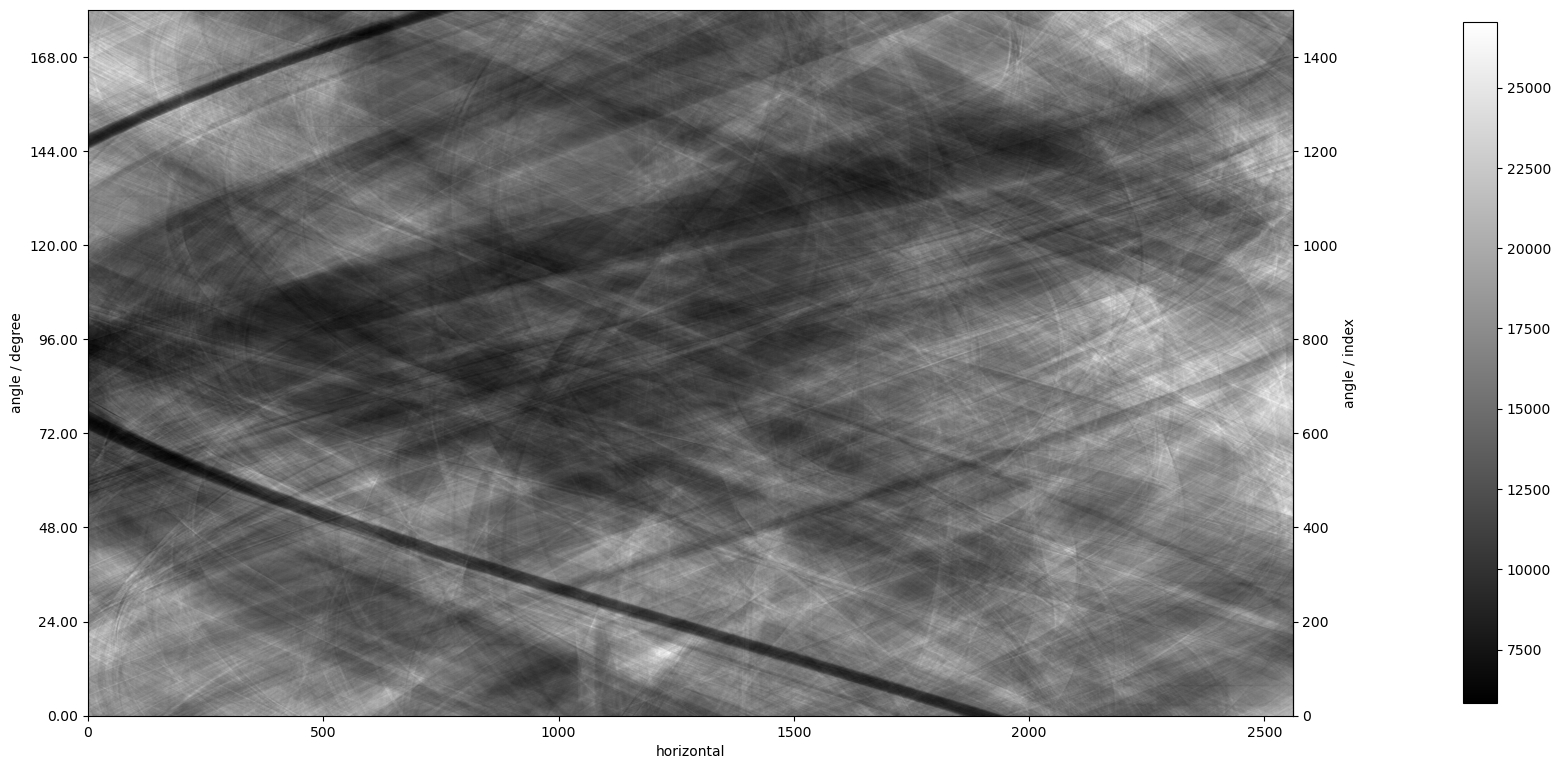

In [6]:
ag = AcquisitionGeometry.create_Parallel2D()  \
         .set_panel(num_pixels=(2560))        \
         .set_angles(angles=np.linspace(0,180,1500,endpoint=False)) \
         .set_labels(['horizontal','angle'])
print(ag.dimension_labels)

sandstone = AcquisitionData(sandstone, geometry=ag, deep_copy=False)
sandstone.reorder('astra')

show2D(sandstone)

### Ground Truth - FBP Reconstruction of pre-processed sandstone

#### Pre-processing:

In [7]:
flats = all_data['X_flat'].astype(np.float32)
flats.shape

darks = all_data['X_dark'].astype(np.float32)
darks.shape

(2560, 30)

In [8]:
sandstone_norm = Normaliser(flat_field=flats.mean(axis=1),
                   dark_field=darks.mean(axis=1))(sandstone)

sandstone_norm = TransmissionAbsorptionConverter()(sandstone_norm)

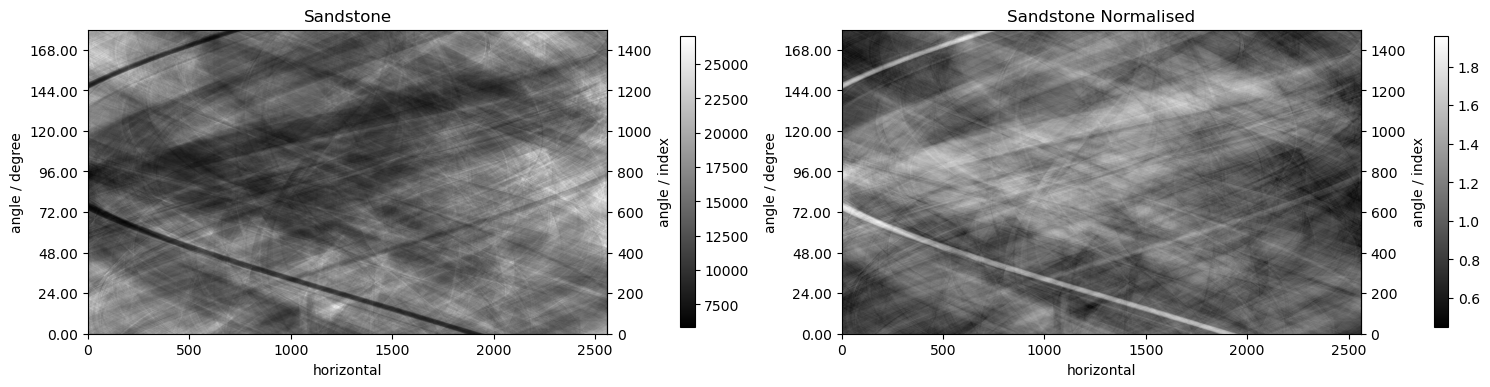

In [9]:
show2D([sandstone, sandstone_norm], title=['Sandstone', 'Sandstone Normalised'])

In [10]:
padsize = 600
sandstone_pad = Padder.edge(pad_width={'horizontal': padsize})(sandstone_norm)

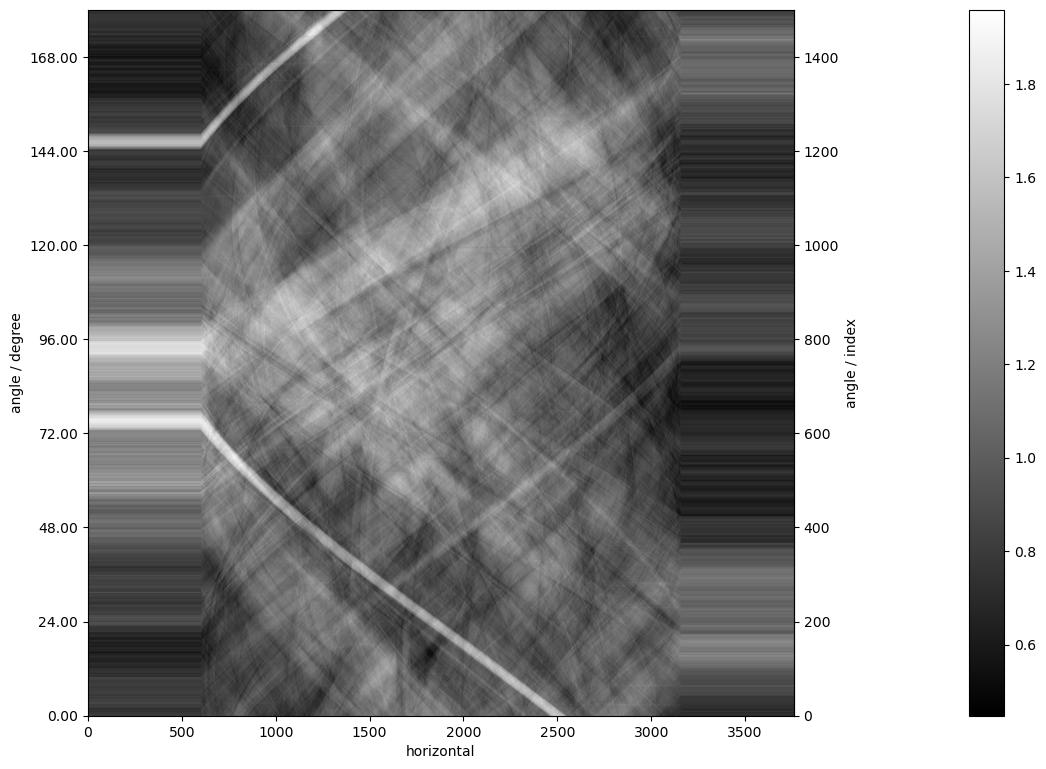

In [11]:
show2D(sandstone_pad)

In [12]:
sandstone_cor = CentreOfRotationCorrector.image_sharpness(backend='astra', search_range=100, tolerance=0.1)(sandstone_pad)
sandstone_cor.geometry.get_centre_of_rotation(distance_units='pixels')

{'offset': (44.489076769386344, 'pixels'), 'angle': (0.0, 'radian')}

#### Obtain ground truth reconstruction:

In [13]:
ig = sandstone_norm.geometry.get_ImageGeometry()
recon = FBP(sandstone_cor, ig, backend='astra').run()

FBP recon

Input Data:
	angle: 1500
	horizontal: 3760

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



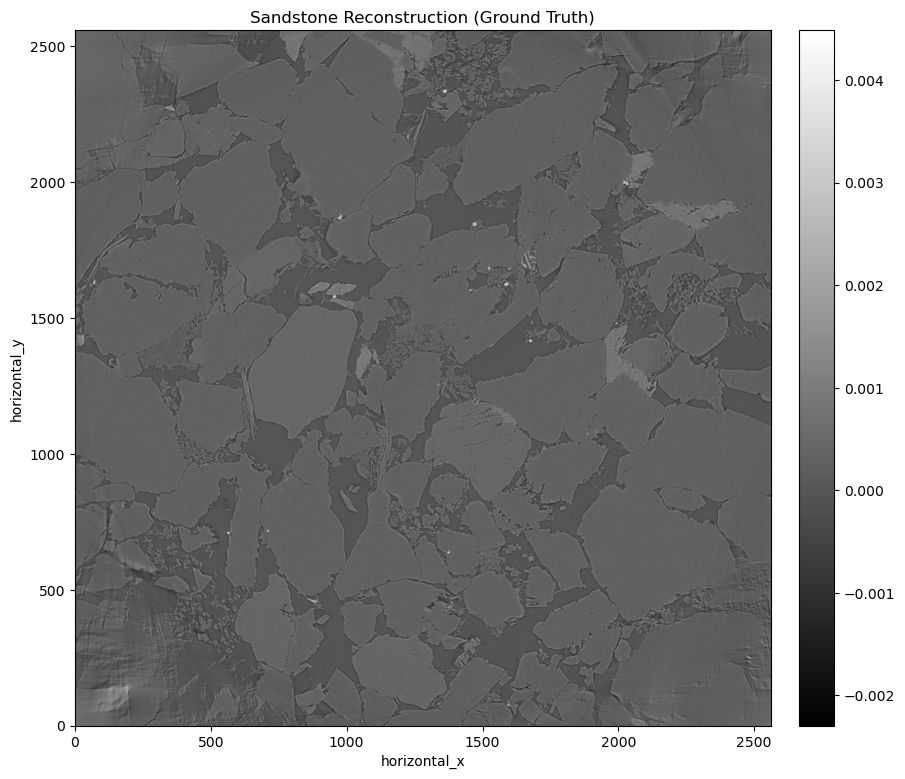

In [14]:
show2D(recon, title='Sandstone Reconstruction (Ground Truth)')

### Generating Test Sinogram - Apply Noise:

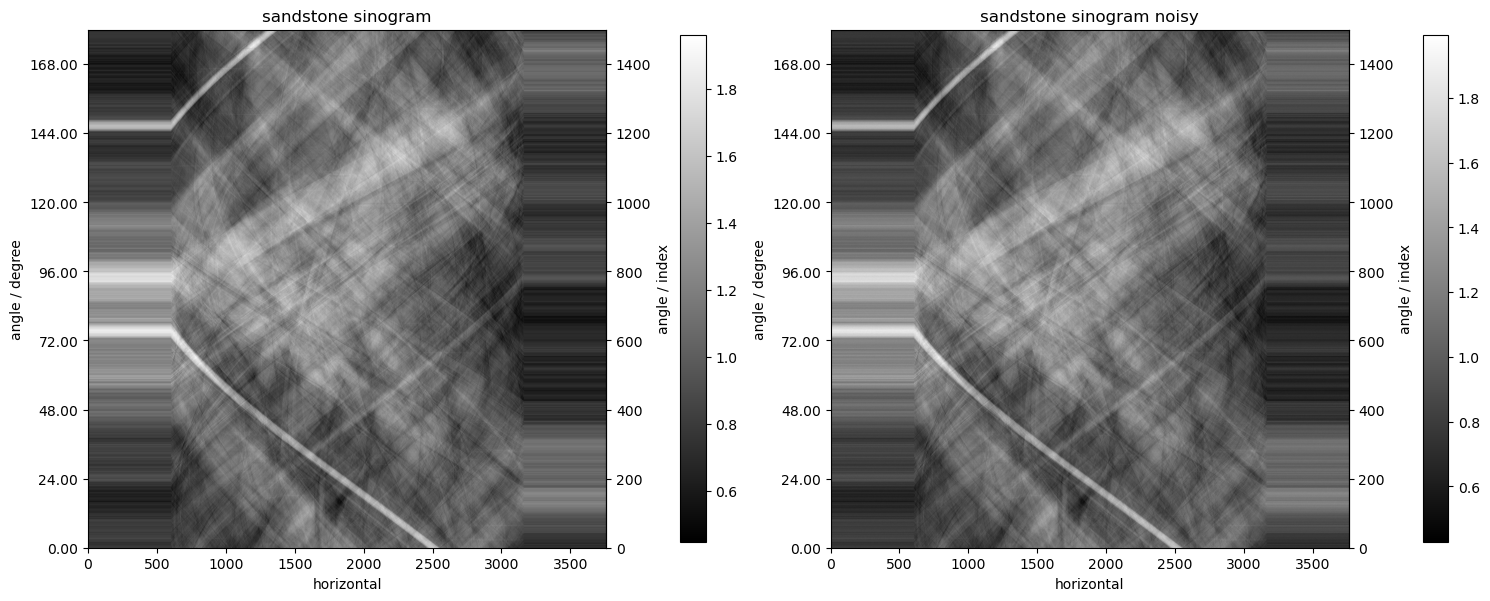

In [15]:
# Incident intensity: lower counts will increase the noise
background_counts = 10000

# Convert the simulated absorption sinogram to transmission values using Lambert-Beer. 
# Use sandstone_cor as mean for Poisson data generation.
# Convert back to absorption sinogram.
counts = background_counts * np.exp(-sandstone_cor.as_array())
noisy_counts = np.random.poisson(counts)
sand_noisy_data = -np.log(noisy_counts/background_counts)

# Create new AcquisitionData object with same geometry as sandstone_cor and fill with noisy data.
sandstone_noisy = sandstone_cor.geometry.allocate()
sandstone_noisy.fill(sand_noisy_data)

plots = [sandstone_cor, sandstone_noisy]
titles = ["sandstone sinogram", "sandstone sinogram noisy"]
show2D(plots, titles)

### CGLS and LSQR without regularisation

Before describing Tikhonov regularisation, we recall the problem solved by LSQR:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}^2_2$$

where,

- $A$ is the projection operator

- $b$ is the acquired data

- $u$ is the unknown image to be solved for, which is done iteratively by progressively minimising the objective function

In the solution provided by LSQR the low frequency components tend to converge faster than the high frequency components. This means we need to control the number of iterations carefully to select the optimal solution.

Set up the LSQR algorithm, including specifying its initial point to start from:

In [16]:
sandstone_noisy.reorder('astra')
ig = sandstone_noisy.geometry.get_ImageGeometry()
ag = sandstone_noisy.geometry # ig and ag need to be same

device = "gpu"
A = ProjectionOperator(ig, ag, device)

initial = ig.allocate(0)

maxit = 100
itsAtATime = 1
N = round(maxit/itsAtATime)

xx = np.arange(0, maxit, itsAtATime)

The `timed_iterations` function below will be used to run the algorithms in increments, so we can store the residuals, errors and time taken per iteration:

Once set up, we can initialise and run the algorithms for the specified number of iterations:

In [17]:
cgls_simple = CGLS(initial=initial, operator=A, data=sandstone_noisy)
times_cgls, rel_res_vec_cgls, rel_err_vec_cgls = timed_iterations(sandstone_noisy, A, sandstone_cor, recon, padsize, cgls_simple, N, itsAtATime)

lsqr_simple = LSQR(initial=initial, operator=A, data=sandstone_noisy)
times_lsqr, rel_res_vec_lsqr, rel_err_vec_lsqr = timed_iterations(sandstone_noisy, A, sandstone_cor, recon, padsize, lsqr_simple, N, itsAtATime)

#### Convergence/reduction of residuals:

The plots below show the progress of the **residuals** and the **relative error** across each iteration.  
The residual is described by the term: 
$$\begin{Vmatrix}A u - b\end{Vmatrix}^2_2$$
Which describes how well the algorithm's reconstruction matches the data.
LSQR is an adaptation of the conjugate gradients method CGLS, so produces the same residuals.
However, LSQR is generally more reliable in the case of numerical errors.

The (relative) error describes how well the reconstruction matches the **ground truth**, which is the FBP reconstruction we computed earlier.

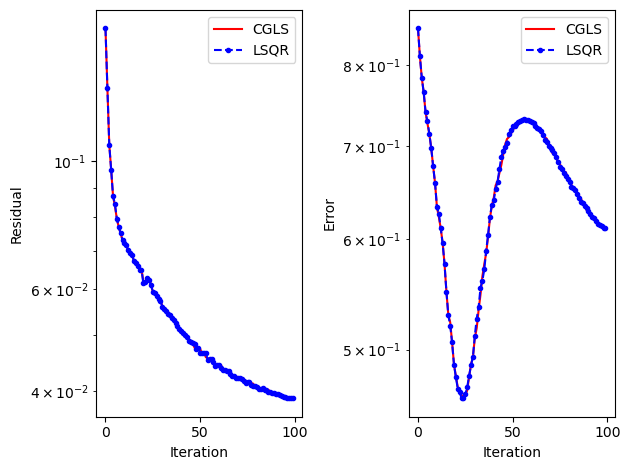

In [18]:
plt.subplot(1,2,1)
plt.semilogy(xx, rel_res_vec_cgls, 'r-', xx, rel_res_vec_lsqr, 'b.--')
plt.xlabel('Iteration') 
plt.ylabel('Residual') 
plt.gca().legend(('CGLS','LSQR'))

plt.subplot(1,2,2)
plt.semilogy(xx, rel_err_vec_cgls, 'r-', xx, rel_err_vec_lsqr, 'b.--')
plt.xlabel('Iteration') 
plt.ylabel('Error') 
plt.gca().legend(('CGLS','LSQR'))
plt.tight_layout()

<p style="font-size:14px; color:#086bb8;">
    <strong>Figure 1:</strong> <br>
    (Left) This graph shows the progress of the residuals across 100 iterations. Both CGLS and LSQR converge to the same residuals, as the iterations for LSQR and CGLS are mathematically equivalent. The residuals themselves decrease (minimise) across the iterations, meaning the algorithms' reconstructions match the data closely. <br>
    (Right) This graph shows the relative error across 100 iterations. Both CGLS and LSQR display identical errors, again because the iterations are equivalent mathematically. This graph shows that the algorithms' reconstructions match the FBP reconstruction (ground truth) most at iteration ~20.
</p>

We can also plot and compare the time taken/elapsed across each iteration:

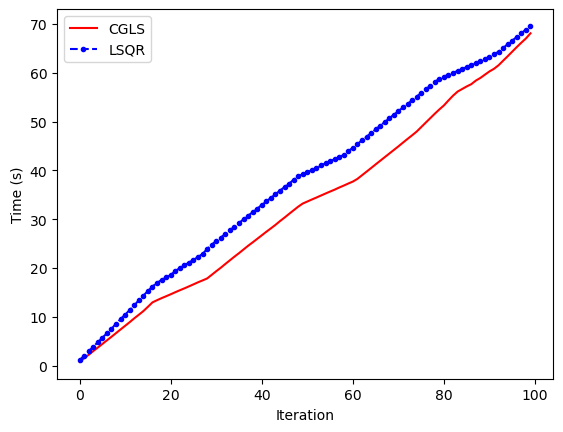

In [19]:
plt.plot(xx, times_cgls, 'r-', xx, times_lsqr, 'b.--')
plt.xlabel('Iteration') 
plt.ylabel('Time (s)')
plt.gca().legend(('CGLS','LSQR'))

<p style="font-size:14px; color:#086bb8;">
    <strong>Figure 2:</strong>
    This graph shows the time elapsed at each iteration for CGLS and LSQR. For both algorithms, this relationship is linear. On this device, the elapsed times across 100 iterations are very similar.
</p>

### Memory Profiling

To profile the memory usage, a custom version of the CGLS file was created.
`CGLS_MP` uses the `memory_profiler` module to profile the `__init__, set_up and run` methods.  
To validate these results, `CGLS_LP` uses `psutil` to manually track the memory usage after each line in these methods. This version also tracks the memory usage in a separate thread, which shows the peak usages in each method. The same was done for LSQR.

Below, we will run the `memory-sandstone.py` script using the modified files, and analyse the outputs:

#### Validating Profiling Tools:

In [20]:
%%capture cgls_mem_prof
!python3 Scripts/memory-sandstone.py cgls_mp

In [21]:
%%capture cgls_line_prof
!python3 Scripts/memory-sandstone.py cgls_lp --track-peak

First, we can view the line-by-line memory increases from the `memory_profiler` output:

In [22]:
print(*cgls_mem_prof.stdout.splitlines()[:117], sep="\n") # Print set_up, __init__ & run 1

Dataset folder already exists in ..
Filename: /home/bih17925/CIL_user_notebooks/015_Memory_Profiling_LSQR_CGLS/Algorithms/CGLSMP.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    81   745.44 MiB   745.44 MiB           1       @profile(precision=2)
    82                                             def set_up(self, initial, operator, data):
    83                                                 r'''Initialisation of the algorithm
    84                                                 Parameters
    85                                                 ------------
    86                                                 operator : Operator
    87                                                     Linear operator for the inverse problem
    88                                                 initial : (optional) DataContainer in the domain of the operator, default is a DataContainer filled with zeros. 
    89                                                     Initial gues

In [23]:
# ImageData and AcquisitionData Sizes
print(f"Estimate of 'initial' (ImageData) size: {initial.size*dtypeSize*MB:.1f} MB")
print(f"Estimate of 'sandstone_noisy' (AcquisitionData) size: {sandstone_noisy.size*dtypeSize*MB:.1f} MB")

Estimate of 'initial' (ImageData) size: 53.9 MB
Estimate of 'sandstone_noisy' (AcquisitionData) size: 21.5 MB


In the `set_up` method, we can see: 
* 3 increases of **~53.9 MB** - these correspond to the size of the **ImageData** space
* 2 increases of **~21.5 MB** - corresponding to the **AcquisitionData** space
* Totalling to an increase of around **~205 MB** 

These increases are expected. In the `__init__` method, the same increase is seen as a result of the call to `set_up` (Highlighted in turquoise).  
In each run, there is a small increase in memory usage due to the iterable in line 158, which calls the `update` method.

For easier visualisation of the Initial and Final usages per method, we process this output and display it as a dataframe. The first usage reading was ~653 MB, which is the memory allocated when loading and processing the dataset. To show the memory usage of the CGLS algorithm alone, this dataframe has been normalised by subtracting the prior memory usage from the results:

In [24]:
cgls_mp = mem_prof_process(cgls_mem_prof, norm=True)
cgls_mp.style.map(lambda val: 'background-color: turquoise' if val > 200 else '', subset='Total Memory Usage (MiB)')\
                 .format(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

,Method,Method Call,Initial Memory Usage (MiB),Final Memory Usage (MiB),Total Memory Usage (MiB)
0,__init__,"def __init__(self, initial=None, operator=None, data=None, **kwargs):",0.00,206.79,206.79
1,set_up,"def set_up(self, initial, operator, data):",0.01,206.79,206.78
2,run 1,"def run(self, iterations=None, callbacks: Optional[List[Callback]]=None, verbose=1, **kwargs):",206.79,206.91,0.12
3,run 2,"def run(self, iterations=None, callbacks: Optional[List[Callback]]=None, verbose=1, **kwargs):",206.91,206.93,0.02
4,run 3,"def run(self, iterations=None, callbacks: Optional[List[Callback]]=None, verbose=1, **kwargs):",206.93,206.93,0.00
5,run 4,"def run(self, iterations=None, callbacks: Optional[List[Callback]]=None, verbose=1, **kwargs):",206.93,206.94,0.01
6,run 5,"def run(self, iterations=None, callbacks: Optional[List[Callback]]=None, verbose=1, **kwargs):",206.94,206.94,0.00
7,run 6,"def run(self, iterations=None, callbacks: Optional[List[Callback]]=None, verbose=1, **kwargs):",206.94,207.06,0.12
8,run 7,"def run(self, iterations=None, callbacks: Optional[List[Callback]]=None, verbose=1, **kwargs):",207.06,207.03,-0.03
9,run 8,"def run(self, iterations=None, callbacks: Optional[List[Callback]]=None, verbose=1, **kwargs):",207.03,207.07,0.04


Let's compare these values to the line-by-line profiling results:

In [25]:
cgls_lp = line_prof_process(cgls_line_prof, norm=True)
cgls_lp.style.map(lambda val: 'background-color: turquoise' if val > 200 else '', subset='Total Memory Usage (MiB)')\
                            .format(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

,Method,Initial Memory Usage (MiB),Final Memory Usage (MiB),Total Memory Usage (MiB)
0,init,0.00,206.88,206.88
1,setup,0.01,206.88,206.87
2,run 1,206.88,206.87,-0.01
3,run 2,206.87,206.80,-0.07
4,run 3,206.80,206.80,0.00
5,run 4,206.80,206.80,0.00
6,run 5,206.80,206.81,0.01
7,run 6,206.81,206.81,0.00
8,run 7,206.81,206.81,0.00
9,run 8,206.81,206.81,0.00


As we can see, the major change in memory corresponding to `set_up` and `__init__` are the same, with minor variations in the memory usages of the `run` calls.

#### Peak Memory Usages:
We have validated the memory usage tracking using two techniques. For the remainder of the notebook, we will be using output snippets from both to illustrate memory changes.

With the line-by-line profiling technique, we can also take a look at the peak memory usages that were measured on a separate thread, and the corresponding calls:

In [26]:
cgls_lp = line_peak_process(cgls_line_prof, norm=True)
cgls_lp.style.apply(
    lambda x: ['background-color: pink' if (58 > val > 50) and (i % 2 == 1) else '' for i, val in enumerate(x)],
    subset='Peak Memory Increase (MiB)')\
    .format(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

,Method,Initial Memory Usage (MiB),Peak Memory,Final Memory Usage (MiB),Total Memory Usage (MiB),Peak Memory Increase (MiB),Peak Line
0,init,0.00,206.88,206.88,206.88,206.88,"self.set_up(initial=initial, operator=operator, data=data)"
1,setup,0.01,206.88,206.88,206.87,206.87,self.normx = self.x.norm()
2,run 1,206.88,260.82,206.87,-0.01,53.94,update(self)
3,update 1,206.89,260.82,206.87,-0.02,53.93,"self.operator.direct(self.p, out=self.q)"
4,run 2,206.87,260.73,206.80,-0.07,53.86,update(self)
5,update 2,206.87,260.73,206.80,-0.07,53.86,"self.operator.direct(self.p, out=self.q)"
6,run 3,206.80,260.65,206.80,0.00,53.85,update(self)
7,update 3,206.80,260.65,206.80,0.00,53.85,"self.operator.direct(self.p, out=self.q)"
8,run 4,206.80,260.67,206.80,0.00,53.87,update(self)
9,update 4,206.80,260.67,206.80,0.00,53.87,"self.operator.direct(self.p, out=self.q)"


This table shows that CGLS' `set_up` and `__init__` calls do not have a spike in memory that exceeds the final usage. However, during the runs, the `update(self)` call produces peak increases around the size of the ImageData space. This memory usage is transient, and is released by the time the call is finished.

Looking at the **Method**=`update` Peak lines (Highlighted in pink), we can see the biggest peak is attributed to the line `self.operator.direct(self.p, out=self.q)`, which creates a copy of the ImageData space during its execution, and releases the memory after it has run.

Below, we visualise this by plotting the total memory increases and the peak memory increases as sequential line graphs:

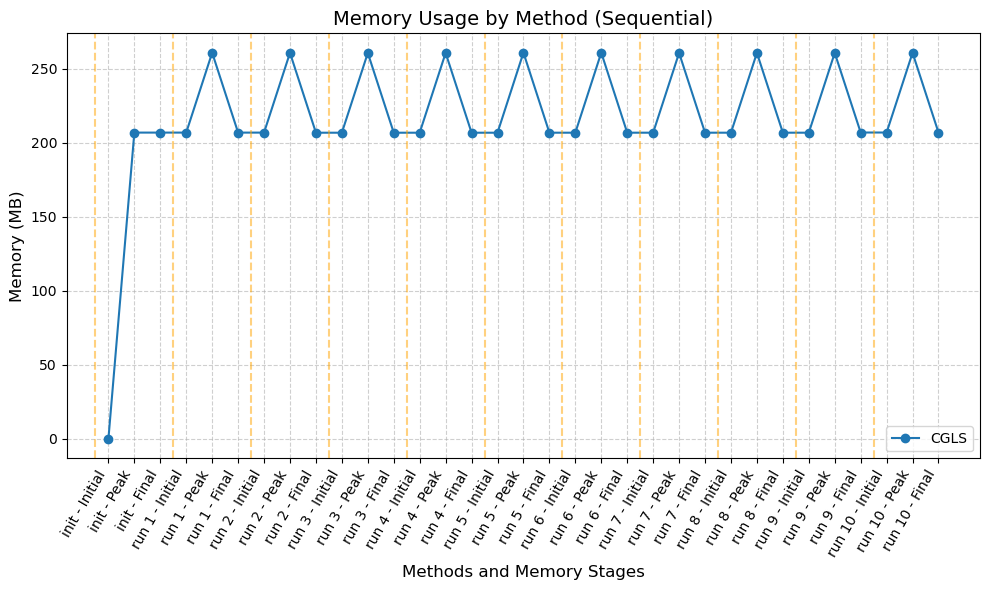

In [27]:
plot_mem((cgls_lp,), ("CGLS",))

<p style="font-size:14px; color:#086bb8;">
    <strong>Figure 3:</strong> 
    This graph shows the memory usages before (initial), during (peak) and after (final) the 'init' and 'run' methods in CGLS. The first two points show the ~205 MB memory increase during 'init', which remains stable. The spikes during each subsequent run show that the memory usage reaches a peak, and then drops back down, resulting in a net increase of ~0 MB. This is consistent across all 'run' calls (iterations).
</p>

#### Comparison With LSQR:
Let's compare this to LSQR's memory usage:

In [28]:
%%capture lsqr_line_prof
!python3 Scripts/memory-sandstone.py lsqr_lp --track-peak

In [29]:
lsqr_lp = line_peak_process(lsqr_line_prof, norm=True)
lsqr_lp.style.apply(
    lambda x: ['background-color: pink' if (58 > val > 50) and (i % 2 == 1) else '' for i, val in enumerate(x)],
    subset='Peak Memory Increase (MiB)')\
    .map(lambda val: 'background-color: turquoise' if val > 200 else '', subset='Total Memory Usage (MiB)')\
    .map(lambda val: 'background-color: orange' if 58 > val > 50 else '', subset='Total Memory Usage (MiB)')\
    .format(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

,Method,Initial Memory Usage (MiB),Peak Memory,Final Memory Usage (MiB),Total Memory Usage (MiB),Peak Memory Increase (MiB),Peak Line
0,init,0.00,206.92,206.92,206.92,206.92,"self.set_up(initial=initial, operator=operator, data=data)"
1,setup,0.00,206.92,206.92,206.92,206.92,self.tmp_range = data.geometry.allocate(None)
2,run 1,206.92,260.88,260.75,53.83,53.96,update(self)
3,update 1,206.93,260.88,260.75,53.82,53.95,"self.v.sapyb(-self.beta, self.tmp_domain, 1., out=self.v)"
4,run 2,260.75,314.80,260.72,-0.03,54.05,update(self)
5,update 2,260.75,314.80,260.72,-0.03,54.05,"self.operator.direct(self.v, out=self.tmp_range)"
6,run 3,260.72,314.80,260.72,0.00,54.08,update(self)
7,update 3,260.72,314.80,260.72,0.00,54.08,"self.operator.direct(self.v, out=self.tmp_range)"
8,run 4,260.72,314.81,260.92,0.20,54.09,update(self)
9,update 4,260.72,314.81,260.80,0.08,54.09,"self.operator.direct(self.v, out=self.tmp_range)"


The table and plots show that LSQR has a **the same setup cost as CGLS** (Highlighted in turquoise).  
We also see the same Peak Increase in LSQR's `run` calls, again due to the ImageData copy made during `update`'s `self.operator.direct(self.v, out=self.tmp_range)` call (Highlighted in pink), which is deallocated after this line is complete.

Notably, there is a ~**54 MB increase** in total memory usage in the first `run`/`update` calls (Highlighted in orange). This is because in `set_up`, `self.tmp_domain` is initialised with `None`, which does not allocate memory. But when calling the first `update`, the line `self.operator.adjoint(self.u, out=self.tmp_domain)` replaces the `None`s with values, which results in memory allocation.

In total with the initialisation cost, LSQR makes:
* 4 increases of **~53.9 MB** - corresponding to the size of the **ImageData** space
* 2 increases of **~21.5 MB** - corresponding to the **AcquisitionData** space

The raw line-by-line output below shows the `self.operator.direct` peak and subsequent deallocation, and the `self.operator.adjoint` increase:

In [30]:
# Uncomment to view line-by-line & peak usage output:
print(*lsqr_line_prof.stdout.splitlines()[110:236], sep="\n") # Truncated to show run 1 & update 1

Memory Usage Log (Time, Memory in MB): 09:13:36.358940, 875.36 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.369353, 875.36 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.379602, 875.36 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.389865, 875.36 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.400180, 875.36 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.410427, 875.36 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.420746, 875.36 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.431067, 875.36 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.441377, 875.36 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.451708, 875.36 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.461959, 875.36 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.472275, 875.36 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.482514, 875.36 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.492822, 875.36 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.503145, 875.36

In contrast to the second `run`/`update` calls, we still see a `self.operator.direct` peak, but no overall usage change from `self.operator.adjoint`:

In [31]:
print(*lsqr_line_prof.stdout.splitlines()[237:349], sep="\n") # Truncated to show run 2 & update 2

Memory Usage Log (Time, Memory in MB): 09:13:36.882829, 1005.68 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.893070, 1005.68 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.903356, 1005.68 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.913626, 1005.68 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.923878, 1005.68 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.934105, 1005.68 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.944341, 1005.68 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.954595, 1005.68 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.964862, 1005.68 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.975170, 1005.68 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.985436, 1005.68 MB

Memory Usage Log (Time, Memory in MB): 09:13:36.995663, 1005.68 MB

Memory Usage Log (Time, Memory in MB): 09:13:37.005890, 1005.68 MB

Memory Usage Log (Time, Memory in MB): 09:13:37.016211, 1005.68 MB

Memory Usage Log (Time, Memory in MB): 09:13:37.

Below is a graph illustrating the overall trends across the methods, showing the comparison for CGLS and LSQR:

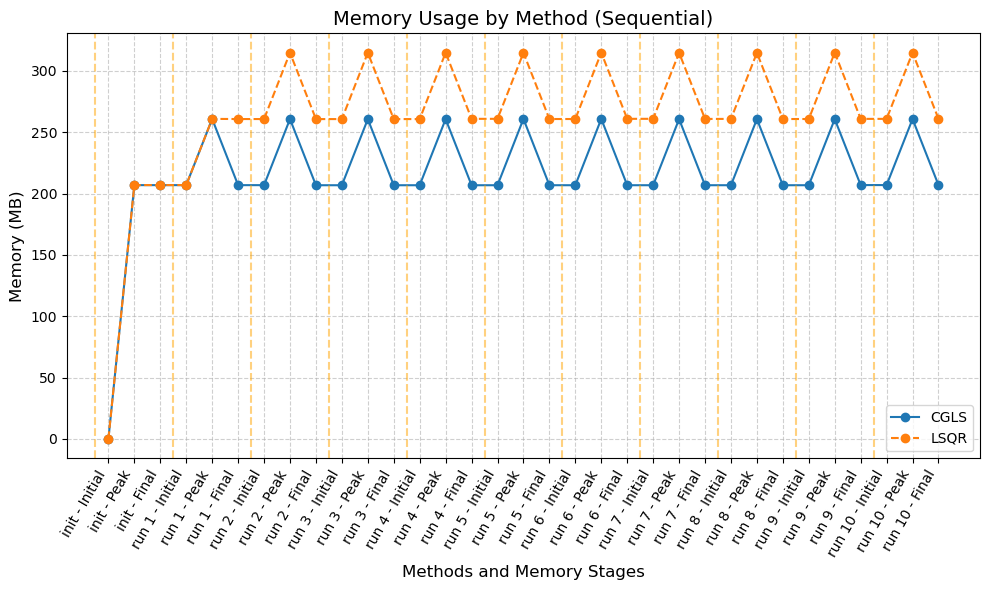

In [32]:
plot_mem(dfs=(cgls_lp, lsqr_lp), algNms=("CGLS", "LSQR"))

<p style="font-size:14px; color:#086bb8;">
    <strong>Figure 4:</strong> 
    This graph shows the memory usages before (initial), during (peak) and after (final) the 'init' and 'run' methods in CGLS (Blue) and LSQR (Orange). The first two points show the memory increase during 'init', which remains stable. Unlike CGLS, LSQR's first 'run' (iteration) shows another memory increase, which also stays consistent and shows that LSQR uses more memory than CGLS. <br>
    The spikes during each subsequent run show that the memory usage reaches a peak, and then drops back down, resulting in a net increase of ~0 MB. This is consistent across all 'run' calls (iterations).
</p>

LSQR creates 4 copies of the ImageData space, and 2 copies of the AcquisitionData, totalling to ~**259 MB**. This can be seen clearly in the breakdown below:

In [33]:
%%capture lsqr_mem_prof
!python3 Scripts/memory-sandstone.py lsqr_mp # Uncomment to run memory_profiler breakdown

In [34]:
# Uncomment to see memory_profiler breakdown:
print(*lsqr_mem_prof.stdout.splitlines()[:42], sep="\n") # Print set_up
print(*lsqr_mem_prof.stdout.splitlines()[77:135], sep="\n") # Print run 1

Dataset folder already exists in ..
Filename: /home/bih17925/CIL_user_notebooks/015_Memory_Profiling_LSQR_CGLS/Algorithms/LSQRMP.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    92    745.0 MiB    745.0 MiB           1       @profile
    93                                             def set_up(self, initial, operator, data):
    94                                                 r'''Initialisation of the algorithm
    95                                                 Parameters
    96                                                 ------------
    97                                                 operator : Operator
    98                                                     Linear operator for the inverse problem
    99                                                 initial : (optional) DataContainer in the domain of the operator, default is a DataContainer filled with zeros. 
   100                                                     Initial guess 
   101    

### Tikhonov regularisation using CGLS and LSQR - with or without a block

#### Tikhonov regularisation

We can add a regularisation term to problem solved by CGLS; this gives us the minimisation problem in the following form, which is known as Tikhonov regularisation:
$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b \end{Vmatrix}^2_2 + \alpha^2\|u\|^2_2$$

where,

- $A$ is the projection operator

- $b$ is the acquired data

- $u$ is the unknown image to be solved for

- $\alpha$ is the regularisation parameter


The first term measures the fidelity of the solution to the data. The second term meausures the fidelity to the prior knowledge we have imposed on the system, operator $L$. $\alpha$ controls the trade-off between these terms. $L$ is often chosen to be a smoothing operator like the identity matrix, or a gradient operator **constrained to the squared L2-norm**.

This can be re-written equivalently in the block matrix form:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\binom{A}{\alpha I} u - \binom{b}{0}\end{Vmatrix}^2_2$$

With the definitions:

- $\tilde{A} = \binom{A}{\alpha I}$

- $\tilde{b} = \binom{b}{0}$

this can now be recognised as a least squares problem:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\tilde{A} u - \tilde{b}\end{Vmatrix}^2_2$$

and being a least squares problem, it can be solved using CGLS with $\tilde{A}$ as operator and $\tilde{b}$ as data.


LSQR in CIL has the option to include Tikhonov regularisation without using blocks. In this section, we will compare LSQR Tikhonov with a block, CGLS with a block, and LSQR Tikhonov without a block.

Set up the algorithms:

In [35]:
initial = ig.allocate(0)

L = IdentityOperator(ig)
alpha = 0.1

operator_block = BlockOperator(A, alpha*L)
zero_data = L.range.allocate(0)
data_block = BlockDataContainer(sandstone_noisy, zero_data)

maxit = 100
itsAtATime = 1
N = round(maxit/itsAtATime)

xx = np.arange(0, maxit, itsAtATime)

In [36]:
cgls_tik_block = CGLS(initial=initial, operator=operator_block, data=data_block, update_objective_interval = 10)
times_cgls_tik_block, rel_res_vec_cgls_tik_block, rel_err_vec_cgls_tik_block = timed_iterations(sandstone_noisy, A, sandstone_cor, recon, padsize, cgls_tik_block, N, itsAtATime)

lsqr_tik_block = LSQR(initial=initial, operator=operator_block, data=data_block, update_objective_interval = 10)
times_lsqr_tik_block, rel_res_vec_lsqr_tik_block, rel_err_vec_lsqr_tik_block = timed_iterations(sandstone_noisy, A, sandstone_cor, recon, padsize, lsqr_tik_block, N, itsAtATime)

lsqr_tik_simple = LSQR_Tikhonov(initial=initial, operator=A, data=sandstone_noisy, alpha = alpha)
times_lsqr_tik_simple, rel_res_vec_lsqr_tik_simple, rel_err_vec_lsqr_tik_simple = timed_iterations(sandstone_noisy, A, sandstone_cor, recon, padsize, lsqr_tik_simple, N, itsAtATime)

#### Convergence/reduction of residuals:

The plots below show the progress of the residuals across each iteration, and the error across iterations:

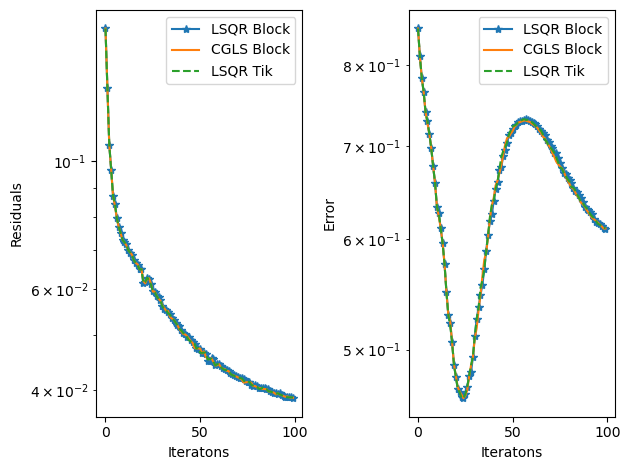

In [37]:
plt.subplot(1,2,1)
plt.semilogy(xx, rel_res_vec_lsqr_tik_block, '*-', xx, rel_res_vec_cgls_tik_block, '-', xx, rel_res_vec_lsqr_tik_simple, '--')
plt.xlabel('Iteratons') 
plt.ylabel('Residuals') 
plt.gca().legend(('LSQR Block', 'CGLS Block', 'LSQR Tik'))

plt.subplot(1,2,2)
plt.semilogy(xx, rel_err_vec_lsqr_tik_block, '*-', xx, rel_err_vec_cgls_tik_block, '-', xx, rel_err_vec_lsqr_tik_simple, '--')
plt.xlabel('Iteratons') 
plt.ylabel('Error') 
plt.gca().legend(('LSQR Block', 'CGLS Block', 'LSQR Tik'))
plt.tight_layout()

<p style="font-size:14px; color:#086bb8;">
    <strong>Figure 5:</strong> <br>
    (Left) This graph shows the progress of the residuals across 100 iterations. CGLS Block, LSQR Block and LSQR Tikhonov's iterations are equivalent mathematically, so they converge to the same residuals. The residuals themselves decrease (minimise) across the iterations, meaning the algorithms' reconstructions match the data closely. <br>
    (Right) This graph shows the relative error across 100 iterations. All 3 algorithms display identical errors due to mathematically equivalent iterations. This graph shows that the algorithms' reconstructions match the FBP reconstruction (ground truth) most at iteration ~20.
</p>

Compare the time taken/elapsed across each iteration for the 3 algorithms:

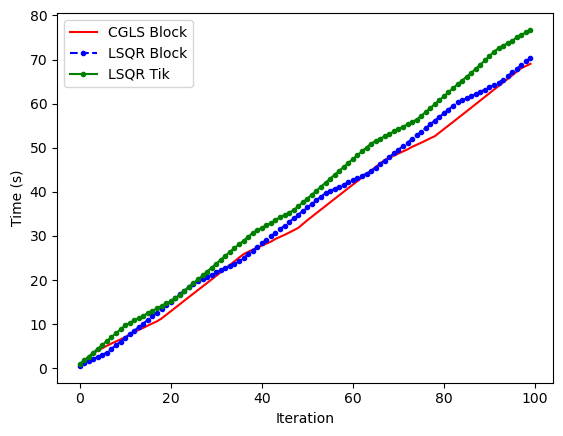

In [38]:
plt.plot(xx, times_cgls_tik_block, 'r-', xx, times_lsqr_tik_block, 'b.--', xx, times_lsqr_tik_simple, 'g.-' )
plt.xlabel('Iteration') 
plt.ylabel('Time (s)')
plt.gca().legend(('CGLS Block', 'LSQR Block', 'LSQR Tik'))

<p style="font-size:14px; color:#086bb8;">
    <strong>Figure 6:</strong> 
    This graph shows the time elapsed at each iteration for CGLS Block, LSQR Block and LSQR Tikhonov. For all algorithms, this relationship is linear. On this device, the elapsed times across 100 iterations are very similar, with CGLS Block being slightly faster overall.
</p>

### Memory costs for LSQR+Block, CGLS+Block and LSQR+Tikhonov

#### Setting Up Memory Tracking:

Setup the memory tracking for the three algorithms:

In [39]:
%%capture cgls_block_prof
!python3 Scripts/memory-sandstone.py cgls_lp_tik_block --track-peak

In [40]:
%%capture lsqr_block_prof
!python3 Scripts/memory-sandstone.py lsqr_lp_tik_block --track-peak

In [41]:
%%capture lsqr_block_mp
!python3 Scripts/memory-sandstone.py lsqr_mp_tik_block 

In [42]:
%%capture lsqr_tik_prof
!python3 Scripts/memory-sandstone.py lsqr_tik_lp --track-peak

In [43]:
%%capture lsqr_tik_mp
!python3 Scripts/memory-sandstone.py lsqr_tik_mp

#### Memory Usage Results: 

In [44]:
# ImageData and AcquisitionData Sizes
print(f"Estimate of 'initial' (ImageData) size: {initial.size*dtypeSize*MB:.1f} MB")
print(f"Estimate of 'sandstone_noisy' (AcquisitionData) size: {sandstone_noisy.size*dtypeSize*MB:.1f} MB")
print(f"Estimate of 'data_block' (Block AcquisitionData) size: {(sandstone_noisy.size+zero_data.size)*dtypeSize*MB:.1f} MB")

Estimate of 'initial' (ImageData) size: 53.9 MB
Estimate of 'sandstone_noisy' (AcquisitionData) size: 21.5 MB
Estimate of 'data_block' (Block AcquisitionData) size: 75.4 MB


In the setup for CGLS Block, the ImageData space is 53.9 MB but the (Block) AcquisitionData is now 75.4 MB.  
Since the algorithm is the same, we expect the same number of increases as before. In total, we expect a setup increase of:
(53.9 * 3) + (75.4 * 2) = **~312.5 MB** (Highlighted in turquoise).

In the dataframe below, there is a (temporary) peak increase of ~129.5 MB in the first `update` (Highlighted in pink) due to the line `self.operator.direct(self.p, out=self.q)`. This corresponds to the ImageData and Block AcquisitionData sizes: 53.9 + 75.4 = ~129.3 MB. 
Most of this memory is deallocated by the end of this line, ~21.5 MB (1x original AcquisitionData) stays occupied in the total usage (Highlighted in orange). 

The subsequent `update` calls have a peak of ~107.9 MB, which is 1x AcqData (~21.5) less than the previous peak, suggesting that the AcqData buffer array in `self.q` is populated with values during the first call to `update`.

In total, CGLS Block makes:
* 3 copies of ImgData (53.9 MB)
* 2 copies of Block AcqData (75.4 MB)
* 1 copy of AcqData (21.5 MB)

The CGLS Block DataFrame shows these results below:

In [45]:
cgls_block_lp = line_peak_process(cgls_block_prof, norm=True)
cgls_block_lp.iloc[:12].style.apply(
    lambda x: ['background-color: pink' if (134 > val > 126) and (i % 2 == 1) else '' for i, val in enumerate(x)],
    subset='Peak Memory Increase (MiB)')\
    .map(lambda val: 'background-color: turquoise' if val > 300 else '', subset='Total Memory Usage (MiB)')\
    .map(lambda val: 'background-color: orange' if 24 > val > 18 else '', subset='Total Memory Usage (MiB)')\
    .format(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

,Method,Initial Memory Usage (MiB),Peak Memory,Final Memory Usage (MiB),Total Memory Usage (MiB),Peak Memory Increase (MiB),Peak Line
0,init,0.00,314.63,314.63,314.63,314.63,"self.set_up(initial=initial, operator=operator, data=data)"
1,setup,0.00,314.63,314.63,314.63,314.63,self.q = self.operator.range_geometry().allocate()
2,run 1,314.63,368.73,314.90,0.27,54.10,update(self)
3,update 1,314.78,368.73,314.90,0.12,53.95,"self.operator.adjoint(self.r, out=self.s)"
4,run 2,314.90,368.87,314.90,0.00,53.97,update(self)
5,update 2,314.90,368.87,314.90,0.00,53.97,"self.operator.direct(self.p, out=self.q)"
6,run 3,314.90,368.88,314.91,0.01,53.98,update(self)
7,update 3,314.90,368.88,314.91,0.01,53.98,"self.operator.adjoint(self.r, out=self.s)"
8,run 4,314.91,368.93,314.99,0.08,54.02,update(self)
9,update 4,314.91,368.93,314.96,0.05,54.02,"self.operator.adjoint(self.r, out=self.s)"


We expect the same with LSQR block, in this case, 4 copies of ImageData and 2 copies of Block AcquisitionData, with an extra 21.5 MB allocated for the original AcquisitionData.  
In `set_up`, the allocations (Highlighted in turquoise) are: (53.9 * 3) + 75.4 + 21.5 = **~258.6 MB**  
in the first `update`, the allocations (Highlighted in orange) are: 53.9 + 75.4 = **~129.3 MB**  

The memory increases in `update` 1 occur because the buffer arrays initialised in `set_up` become populated with values.

The peak of ~183 MB (Highlighted in pink) is due to `self.operator.direct(self.v, out=self.tmp_range)` creating temp buffers of ImgData + Block AcqData, and 
`self.operator.adjoint(self.u, out=self.tmp_domain)` creating 2 buffers of ImgData during `update` 1.

In total, LSQR Block makes:
* 4 copies of ImgData (53.9 MB)
* 2 copies of Block AcqData (75.4 MB)
* 1 copy of AcqData (21.5 MB)

In [46]:
lsqr_block_lp = line_peak_process(lsqr_block_prof, norm=True)
lsqr_block_lp.iloc[:12].style.apply(
    lambda x: ['background-color: pink' if (190 > val > 175) and (i % 2 == 1) else '' for i, val in enumerate(x)],
    subset='Peak Memory Increase (MiB)')\
    .map(lambda val: 'background-color: turquoise' if val > 255 else '', subset='Total Memory Usage (MiB)')\
    .map(lambda val: 'background-color: orange' if 134 > val > 126 else '', subset='Total Memory Usage (MiB)')\
    .format(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

,Method,Initial Memory Usage (MiB),Peak Memory,Final Memory Usage (MiB),Total Memory Usage (MiB),Peak Memory Increase (MiB),Peak Line
0,init,0.00,260.83,260.83,260.83,260.83,"self.set_up(initial=initial, operator=operator, data=data)"
1,setup,0.00,260.83,260.83,260.83,260.83,self.tmp_range = data.geometry.allocate(None)
2,run 1,260.83,422.67,368.62,107.79,161.84,update(self)
3,update 1,260.87,422.67,368.62,107.75,161.80,"self.operator.adjoint(self.u, out=self.tmp_domain)"
4,run 2,368.62,422.68,368.63,0.01,54.06,update(self)
5,update 2,368.62,422.68,368.63,0.01,54.06,"self.operator.adjoint(self.u, out=self.tmp_domain)"
6,run 3,368.63,422.68,368.63,0.00,54.05,update(self)
7,update 3,368.63,422.68,368.63,0.00,54.05,"self.operator.direct(self.v, out=self.tmp_range)"
8,run 4,368.63,422.72,368.79,0.16,54.09,update(self)
9,update 4,368.63,422.72,368.70,0.07,54.09,"self.operator.adjoint(self.u, out=self.tmp_domain)"


In [47]:
# ImageData and AcquisitionData Sizes
print(f"Estimate of 'initial' (ImageData) size: {initial.size*dtypeSize*MB:.1f} MB")
print(f"Estimate of 'sandstone_noisy' (AcquisitionData) size: {sandstone_noisy.size*dtypeSize*MB:.1f} MB")

Estimate of 'initial' (ImageData) size: 53.9 MB
Estimate of 'sandstone_noisy' (AcquisitionData) size: 21.5 MB


The setup for LSQR Tikhonov does not use the Block operator, so the ImageData and AcquisitionData sizes are **53.9 MB** and **21.5 MB**, respectively.

We expect the Total Memory Usage to be the same as LSQR run previously, without the BlockOperator:
* 4 copies of ImageData (3 in `set_up` (Highlighted in turquoise), 1 in `run`/`update` (Highlighted in orange))
* 2 copies of AcquisitionData (Highlighted in turquoise)

Totalling to a usage of: (53.9 * 4) + (21.5 * 2) = **~258.6 MB**. This is shown in the outputs below, showing LSQR Tikhonov will use less memory than the block versions of CGLS and LSQR.

In [48]:
# Uncomment to see memory_profiler breakdown:
print(*lsqr_tik_mp.stdout.splitlines()[:49], sep="\n") # Print set_up
print(*lsqr_tik_mp.stdout.splitlines()[77:135], sep="\n") # Print run 1

Dataset folder already exists in ..
Filename: /home/bih17925/CIL_user_notebooks/015_Memory_Profiling_LSQR_CGLS/Algorithms/LSQRMP.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    92    745.1 MiB    745.1 MiB           1       @profile
    93                                             def set_up(self, initial, operator, data):
    94                                                 r'''Initialisation of the algorithm
    95                                                 Parameters
    96                                                 ------------
    97                                                 operator : Operator
    98                                                     Linear operator for the inverse problem
    99                                                 initial : (optional) DataContainer in the domain of the operator, default is a DataContainer filled with zeros. 
   100                                                     Initial guess 
   101    

We can see the increase of ~54 MB at the first iteration resulting from the line `self.operator.adjoint(self.u, out=self.tmp_domain)` which is also observed in the non-block version of LSQR:

In [49]:
print(*lsqr_tik_prof.stdout.splitlines()[112:238], sep="\n")

Memory Usage Log (Time, Memory in MB): 09:21:10.023751, 875.56 MB

Memory Usage Log (Time, Memory in MB): 09:21:10.034007, 875.56 MB

Memory Usage Log (Time, Memory in MB): 09:21:10.044331, 875.56 MB

Memory Usage Log (Time, Memory in MB): 09:21:10.054590, 875.56 MB

Memory Usage Log (Time, Memory in MB): 09:21:10.064921, 875.56 MB

Memory Usage Log (Time, Memory in MB): 09:21:10.075204, 875.56 MB

Memory Usage Log (Time, Memory in MB): 09:21:10.085457, 875.56 MB

Memory Usage Log (Time, Memory in MB): 09:21:10.095758, 875.56 MB

Memory Usage Log (Time, Memory in MB): 09:21:10.106039, 875.56 MB

Memory Usage Log (Time, Memory in MB): 09:21:10.116394, 875.56 MB

Memory Usage Log (Time, Memory in MB): 09:21:10.126671, 875.56 MB

Memory Usage Log (Time, Memory in MB): 09:21:10.136976, 875.56 MB

Memory Usage Log (Time, Memory in MB): 09:21:10.147253, 875.56 MB

Memory Usage Log (Time, Memory in MB): 09:21:10.157550, 875.56 MB

Memory Usage Log (Time, Memory in MB): 09:21:10.167837, 875.56

In [50]:
lsqr_tik_lp = line_peak_process(lsqr_tik_prof, norm=True)
lsqr_tik_lp.iloc[:12].style.map(lambda val: 'background-color: turquoise' if val > 204 else '', subset='Total Memory Usage (MiB)')\
    .map(lambda val: 'background-color: orange' if 58 > val > 50 else '', subset='Total Memory Usage (MiB)')\
    .format(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

,Method,Initial Memory Usage (MiB),Peak Memory,Final Memory Usage (MiB),Total Memory Usage (MiB),Peak Memory Increase (MiB),Peak Line
0,init,0.00,206.84,206.84,206.84,206.84,"self.set_up(initial=initial, operator=operator, data=data)"
1,setup,0.00,206.84,206.84,206.84,206.84,self.tmp_range = data.geometry.allocate(None)
2,run 1,206.84,260.82,260.68,53.84,53.98,update(self)
3,update 1,206.86,260.82,260.68,53.82,53.96,"self.v.sapyb(-self.beta, self.tmp_domain, 1., out=self.v)"
4,run 2,260.68,314.73,260.65,-0.03,54.05,update(self)
5,update 2,260.68,314.73,260.65,-0.03,54.05,"self.operator.direct(self.v, out=self.tmp_range)"
6,run 3,260.65,314.77,260.84,0.19,54.12,update(self)
7,update 3,260.65,314.77,260.77,0.12,54.12,"self.operator.direct(self.v, out=self.tmp_range)"
8,run 4,260.84,314.78,260.81,-0.03,53.94,update(self)
9,update 4,260.84,314.78,260.81,-0.03,53.94,"self.operator.direct(self.v, out=self.tmp_range)"


The graphs below show the memory usage trends across the method calls.    
LSQR Tikhonov has the lowest setup and peak memory usages of the algorithms, as the input data was smaller in size.

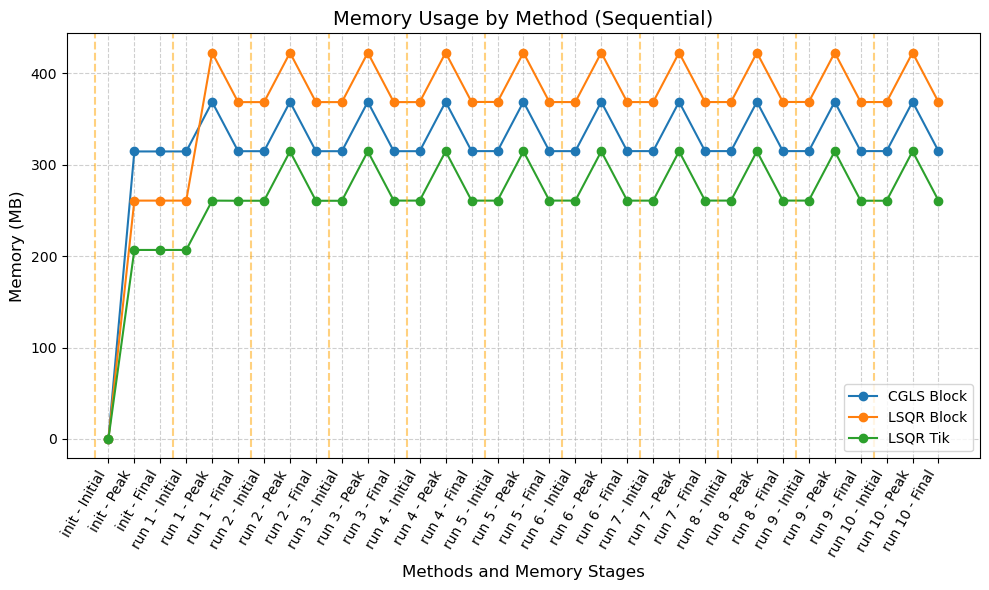

In [51]:
plot_mem(dfs=(cgls_block_lp, lsqr_block_lp, lsqr_tik_lp), algNms=("CGLS Block", "LSQR Block", "LSQR Tik"), linestyles=("-","-","-"))

<p style="font-size:14px; color:#086bb8;">
    <strong>Figure 7:</strong> 
    This graph shows the memory usages before (initial), during (peak) and after (final) the 'init' and 'run' methods in CGLS Block (Blue), LSQR Block (Orange) and LSQR Tikhonov (Green). The first two points show the memory increases during 'init', which remain stable. 
    <br>
    In 'run (iteration) 1`, CGLS Block and LSQR Block show a peak, which then drops down slightly. The graph shows a net increase in memory usage at the end of 'run 1'.
    LSQR Tikhonov shows a net increase in memory usage in `run 1` too, without a peak. 
    <br>
    The spikes during each subsequent run show that the memory usage reaches a peak, and then drops back down, resulting in a net increase of ~0 MB. This is consistent across all 'run' calls (iterations).
    <br>
    Amongst these three algorithms, LSQR Block uses the most memory, and LSQR Tikhonov uses the least.
</p>

### Conclusion:


In this notebook, we showed:
* LSQR and CGLS produce very similar residuals, and perform similarly with respect to iteration time
* The simple version of CGLS uses less memory than LSQR
* LSQR and CGLS Block, and LSQR Tikhonov produce very similar residuals, and show similar iteration times
* LSQR Tikhonov will use the same memory as regular LSQR
* LSQR Tikhonov has the benefit of a regularisation term, which means that there is less likelihood of overfitting to the noise
* The profiling data tells us where the memory usage comes from, and places it could be optimised
* There may be some room to optimise peak memory usage, e.g. in the `ProjectionOperator` code 